In [1]:
import os

In [2]:
classificationRootPath = os.path.join('tf_classification')
if not os.path.exists(classificationRootPath):
    os.mkdir(classificationRootPath)

In [3]:
imagesPath = os.path.join(classificationRootPath, 'images')
if not os.path.exists(imagesPath):
    os.mkdir(imagesPath)

In [ ]:
imagesCroppedPath = os.path.join(classificationRootPath, 'img_cropped')

if os.path.exists(imagesCroppedPath):
    images = os.listdir(imagesCroppedPath)
    for image in images:
        imagePath = os.path.join(imagesCroppedPath, image)
        if(os.path.isfile(imagePath)):
            imageClass = os.path.splitext(image)[0]
            classFolder = os.path.join(imagesPath, imageClass)
            if not os.path.exists(classFolder):
                os.mkdir(classFolder)
            dstImagePath = os.path.join(classFolder, image)
            os.replace(imagePath, dstImagePath)
            print('Moved ', imageClass)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
batch_size = 128

In [27]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    imagesPath,
    validation_split=0.2,
    subset='training',
    seed=1234,
    batch_size=batch_size
)

Found 290280 files belonging to 12095 classes.
Using 232224 files for training.


In [28]:
eval_ds = tf.keras.utils.image_dataset_from_directory(
    imagesPath,
    validation_split=0.2,
    subset='validation',
    seed=1234,
    batch_size=batch_size
)

Found 290280 files belonging to 12095 classes.
Using 58056 files for validation.


In [29]:
class_names = train_ds.class_names

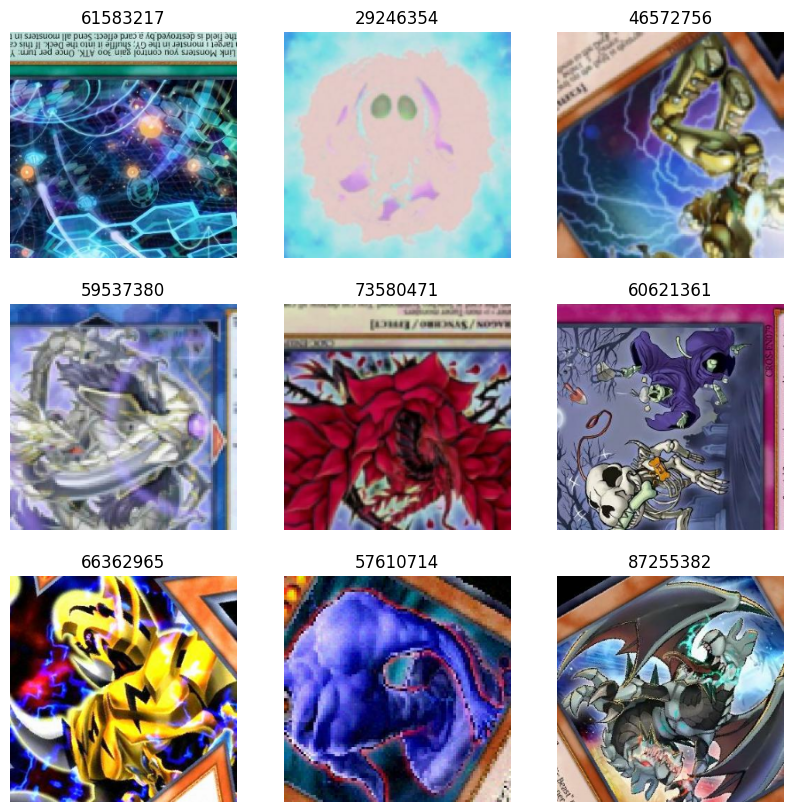

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
img_width = 128
img_height = 128

model = Sequential([
    layers.Resizing(img_height, img_width, input_shape=(None, None, 3)),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names)) 
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=eval_ds,
  epochs=epochs
)

Epoch 1/10


In [15]:
modelsPath = os.path.join(classificationRootPath, 'models')
if not os.path.exists(modelsPath):
    os.mkdir(modelsPath)
    
modelSavePath = os.path.join(modelsPath, 'basic_v1')
if not os.path.exists(modelSavePath):
    os.mkdir(modelSavePath)

model.save(modelSavePath)
    
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(os.path.join(modelSavePath, 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: tf_classification\models\basic_v1\assets


INFO:tensorflow:Assets written to: tf_classification\models\basic_v1\assets


INFO:tensorflow:Assets written to: C:\Users\adinc\AppData\Local\Temp\tmp0n40xmju\assets


INFO:tensorflow:Assets written to: C:\Users\adinc\AppData\Local\Temp\tmp0n40xmju\assets


In [25]:
testImgClass = '28596933'
testImgPath = os.path.join(imagesPath,testImgClass, '28596933_6_aug.jpg' )
test_img = tf.keras.utils.load_img(
    testImgPath
)
test_img_array = tf.keras.utils.img_to_array(test_img)
test_img_array = tf.expand_dims(test_img_array, 0)

predictions = model.predict(test_img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)], ' ', 100*np.max(score))

1/1 [==============================] - 0s 16ms/step
28596933   0.029324842034839094
